# Data

### Libraries

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

### Data preparation

In [2]:
def load_filtered_data(city):
    '''
    Load filtered data from a city
    '''
    file = ['business', 'checkin', 'review', 'tip', 'user']
    data = {}
    for f in file:
        data[f] = pd.read_csv(f'../filtered_cities/{city}_{f}.csv')
    return data

In [3]:
# load data

city = 'St. Louis'
data = load_filtered_data(city)

In [4]:
# load review sentiment data

sentiment_df = pd.read_csv('../nlp/data/review_sentiment.csv')

sentiment_df

,review_id,text,sentiment
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",-1
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,-1
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1
...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1


#### Users

In [5]:
# user data

data['user'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38816 entries, 0 to 38815
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             38816 non-null  object 
 1   name                38815 non-null  object 
 2   review_count        38816 non-null  int64  
 3   yelping_since       38816 non-null  object 
 4   useful              38816 non-null  int64  
 5   funny               38816 non-null  int64  
 6   cool                38816 non-null  int64  
 7   elite               4042 non-null   object 
 8   friends             24671 non-null  object 
 9   fans                38816 non-null  int64  
 10  average_stars       38816 non-null  float64
 11  compliment_hot      38816 non-null  int64  
 12  compliment_more     38816 non-null  int64  
 13  compliment_profile  38816 non-null  int64  
 14  compliment_cute     38816 non-null  int64  
 15  compliment_list     38816 non-null  int64  
 16  comp

In [6]:
# time series for users

user_ts = data['user'][['user_id', 'yelping_since']].copy()
user_ts = user_ts.rename(columns={'yelping_since': 'date'})
user_ts['date'] = pd.to_datetime(user_ts['date'])
user_ts.set_index('date', inplace=True)

user_ts

,user_id
date,
2009-10-07 17:23:44,_crIokUeTCHVK_JVOy-0qQ
2009-07-11 16:47:38,VcLRGCG_VbAo8MxOm76jzA
2008-01-19 22:50:00,MGPQVLsODMm9ZtYQW-g_OA
2007-02-20 18:21:07,AkBtT43dYcttxQ3qOzPBAg
2007-06-15 20:02:41,3oDIaMM1bd7cwN0eKQv-rA
...,...
2019-12-31 04:45:03,wfMvoUM9RUfvlVse6cicgw
2013-09-28 13:07:24,TvxBAEh4RVOAdS45L0-hDQ
2014-09-01 13:37:12,3LKAT9AGKL4034XCSjckZA


In [7]:
# users per day, week, month, year

users_per_day = user_ts.resample('D').size()
users_per_week = user_ts.resample('W').size()
users_per_month = user_ts.resample('ME').size()
users_per_year = user_ts.resample('YE').size()

#### Checkins

In [8]:
# checkin data

data['checkin'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  1088 non-null   object
 1   date         1088 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


In [9]:
# time series for checkins

checkin_ts = data['checkin'].copy()
checkin_ts['date'] = checkin_ts['date'].str.split(', ')
checkin_ts = checkin_ts.explode('date')
checkin_ts['date'] = pd.to_datetime(checkin_ts['date'])
checkin_ts.set_index('date', inplace=True)

checkin_ts

,business_id
date,
2014-10-17 18:14:34,-1m7-ZxGRVRdKa4tFB4eDg
2014-10-29 17:01:04,-1m7-ZxGRVRdKa4tFB4eDg
2014-10-29 17:51:48,-1m7-ZxGRVRdKa4tFB4eDg
2015-03-17 12:35:17,-1m7-ZxGRVRdKa4tFB4eDg
2015-04-14 17:46:26,-1m7-ZxGRVRdKa4tFB4eDg
...,...
2020-01-30 19:40:21,zziDpuuJw-Km1J4BaGpBKA
2020-12-21 22:29:50,zziDpuuJw-Km1J4BaGpBKA
2021-07-10 18:14:38,zziDpuuJw-Km1J4BaGpBKA


In [10]:
# checkins per day, week, month, year

checkins_per_day = checkin_ts.resample('D').size()
checkins_per_week = checkin_ts.resample('W').size()
checkins_per_month = checkin_ts.resample('ME').size()
checkins_per_year = checkin_ts.resample('YE').size()

#### Reviews

In [11]:
# review data

data['review'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63451 entries, 0 to 63450
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    63451 non-null  object
 1   user_id      63451 non-null  object
 2   business_id  63451 non-null  object
 3   stars        63451 non-null  int64 
 4   useful       63451 non-null  int64 
 5   funny        63451 non-null  int64 
 6   cool         63451 non-null  int64 
 7   text         63451 non-null  object
 8   date         63451 non-null  object
dtypes: int64(4), object(5)
memory usage: 4.4+ MB


In [12]:
# time series for reviews

review_ts = data['review'][['review_id', 'date']].copy()
review_ts['date'] = pd.to_datetime(review_ts['date'])
review_ts.set_index('date', inplace=True)

review_ts

,review_id
date,
2011-01-08 23:52:22,NvusujU9_5pIUbn9SZ6hMA
2018-06-09 01:37:02,vHOeBa7aMA_na4rfS2Db5A
2010-03-13 22:33:10,hG9RTxxivb0ZXzEk4JXTXA
2017-12-16 03:11:50,zIVkwgahZjOneChZFUYY4g
2015-04-28 20:29:40,DLczAuvMAlAnY5EeDGhTVg
...,...
2014-08-16 02:47:47,OgoBp7fbXnLSKvsQb4O_tw
2021-12-20 11:58:50,Q7e8EtZMmdknDrQE7huMoQ
2019-10-04 21:57:19,zzMW6zbsFaQMjoGu2bGVdA


In [13]:
# reviews per day, week, month, year

reviews_per_day = review_ts.resample('D').size()
reviews_per_week = review_ts.resample('W').size()
reviews_per_month = review_ts.resample('ME').size()
reviews_per_year = review_ts.resample('YE').size()

#### Sentiments

In [14]:
# time series for negative, neutral, and positive reviews

negative_reviews = sentiment_df[sentiment_df['sentiment'] == -1]['review_id']
negative_review_ts = review_ts[review_ts['review_id'].isin(negative_reviews)]

neutral_reviews = sentiment_df[sentiment_df['sentiment'] == 0]['review_id']
neutral_review_ts = review_ts[review_ts['review_id'].isin(neutral_reviews)]

positive_reviews = sentiment_df[sentiment_df['sentiment'] == 1]['review_id']
positive_review_ts = review_ts[review_ts['review_id'].isin(positive_reviews)]

In [15]:
# time series with review sentiments aggregated

sentiment_scores = sentiment_df[['review_id', 'sentiment']].copy()
review_scores_df = review_ts.merge(sentiment_scores, on='review_id')

sentiment_ts = review_ts.merge(review_scores_df, on='review_id')
sentiment_ts.set_index(review_ts.index, inplace=True)

sentiment_ts

,review_id,sentiment
date,,
2011-01-08 23:52:22,NvusujU9_5pIUbn9SZ6hMA,1
2018-06-09 01:37:02,vHOeBa7aMA_na4rfS2Db5A,-1
2010-03-13 22:33:10,hG9RTxxivb0ZXzEk4JXTXA,-1
2017-12-16 03:11:50,zIVkwgahZjOneChZFUYY4g,1
2015-04-28 20:29:40,DLczAuvMAlAnY5EeDGhTVg,1
...,...,...
2014-08-16 02:47:47,OgoBp7fbXnLSKvsQb4O_tw,1
2021-12-20 11:58:50,Q7e8EtZMmdknDrQE7huMoQ,1
2019-10-04 21:57:19,zzMW6zbsFaQMjoGu2bGVdA,1


In [98]:
# review sentiment time series per month

negative_reviews_per_month = negative_review_ts.resample('ME').size().rename('count')
neutral_reviews_per_month = neutral_review_ts.resample('ME').size().rename('count')
positive_reviews_per_month = positive_review_ts.resample('ME').size().rename('count')

In [17]:
# review sentiment per week and month

sentiment_per_week = sentiment_ts.resample('W').agg({'sentiment': 'mean'})
sentiment_per_month = sentiment_ts.resample('ME').agg({'sentiment': 'mean'})

sentiment_per_month

,sentiment
date,
2005-05-31,1.000000
2005-06-30,1.000000
2005-07-31,NaN
2005-08-31,0.500000
2005-09-30,NaN
...,...
2021-09-30,0.447143
2021-10-31,0.512363
2021-11-30,0.537600


In [18]:
def check_missing_values(sentiment_column):
    '''
    Check missing values in a sentiment column
    '''
    total_null = sentiment_column.isnull().sum()
    total = sentiment_column.shape[0]
    missing_percentage = round((total_null / total) * 100, 2)
    print(f'Total missing values: {total_null} ({missing_percentage}%)')

In [19]:
def deal_with_missing_values(sentiment_column):
    '''
    Deal with missing values in a sentiment column (forward fill, backward fill, then rolling mean)
    '''
    window_size = 3
    sentiment_column = sentiment_column.ffill().bfill()
    sentiment_column = sentiment_column.fillna(sentiment_column.rolling(window_size, min_periods=1).mean())
    return sentiment_column

In [20]:
# deal with missing values in sentiment per week

check_missing_values(sentiment_per_week['sentiment'])
sentiment_per_week['sentiment'] = deal_with_missing_values(sentiment_per_week['sentiment'])
check_missing_values(sentiment_per_week['sentiment'])

Total missing values: 71 (8.15%)
Total missing values: 0 (0.0%)


In [21]:
# deal with missing values in sentiment per month

check_missing_values(sentiment_per_month['sentiment'])
sentiment_per_month['sentiment'] = deal_with_missing_values(sentiment_per_month['sentiment'])
check_missing_values(sentiment_per_month['sentiment'])

Total missing values: 4 (1.99%)
Total missing values: 0 (0.0%)


In [100]:
# save sentiment time series

negative_reviews_per_month.to_csv(f'data/negative_reviews_per_month.csv')
neutral_reviews_per_month.to_csv(f'data/neutral_reviews_per_month.csv')
positive_reviews_per_month.to_csv(f'data/positive_reviews_per_month.csv')
sentiment_per_month.to_csv(f'data/sentiment_per_month.csv')

#### Business categories

In [23]:
# business data

data['business'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   1255 non-null   object 
 1   name          1255 non-null   object 
 2   address       1205 non-null   object 
 3   city          1255 non-null   object 
 4   state         1255 non-null   object 
 5   postal_code   1255 non-null   int64  
 6   latitude      1255 non-null   float64
 7   longitude     1255 non-null   float64
 8   stars         1255 non-null   float64
 9   review_count  1255 non-null   int64  
 10  is_open       1255 non-null   int64  
 11  attributes    1150 non-null   object 
 12  categories    1255 non-null   object 
 13  hours         1190 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 137.4+ KB


In [24]:
# dataframe with business categories

review_data = data['review'].reset_index()

reviews_business = pd.merge(review_data, data['business'], on='business_id')
reviews_business['categories'] = reviews_business['categories'].str.split(', ')
reviews_categories = reviews_business.explode('categories')

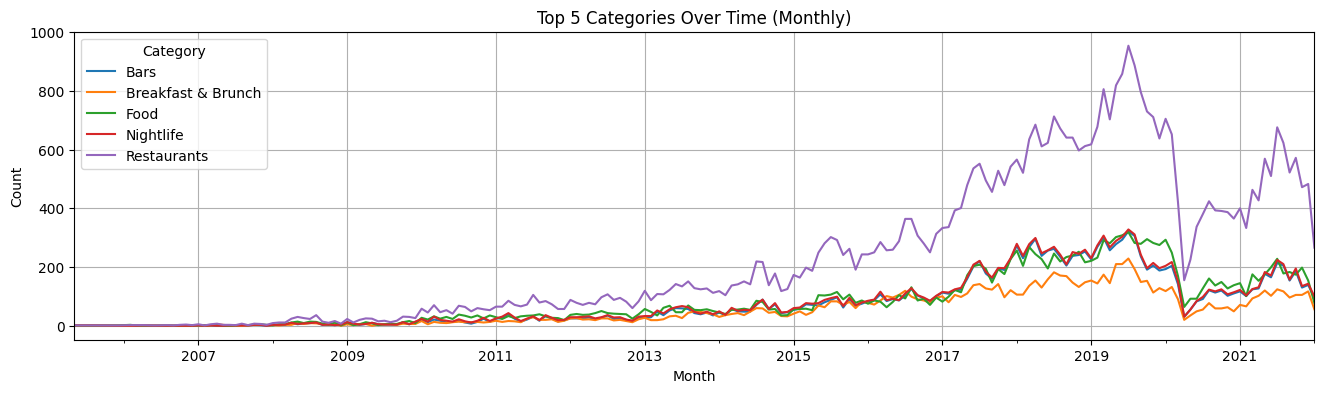

In [25]:
# time series for top 5 categories

reviews_categories['date'] = pd.to_datetime(reviews_categories['date'])
reviews_categories['year_month'] = reviews_categories['date'].dt.to_period('M')

top_categories = reviews_categories['categories'].value_counts().nlargest(5).index
filtered_df = reviews_categories[reviews_categories['categories'].isin(top_categories)]
grouped_df = filtered_df.groupby(['year_month', 'categories']).size().unstack(fill_value=0)

grouped_df.plot(figsize=(16, 4))
plt.title('Top 5 Categories Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Category')
plt.grid(True)
plt.show()

In [26]:
# time series for sentiment per category (restaurants, nightlife, breakfast & brunch)

review_id_cat = reviews_categories[['review_id', 'categories']]
review_id_cat = review_id_cat.drop_duplicates()

sentiment_ts_dup = sentiment_ts.reset_index()
sentiment_category_ts = sentiment_ts_dup.merge(review_id_cat, on='review_id')
sentiment_category_ts = sentiment_category_ts.set_index('date')

sentiment_restaurants_ts = sentiment_category_ts[sentiment_category_ts['categories'].isin(['Restaurants'])]
sentiment_nightlife_ts = sentiment_category_ts[sentiment_category_ts['categories'].isin(['Nightlife'])]
sentiment_breakfast_brunch_ts = sentiment_category_ts[sentiment_category_ts['categories'].isin(['Breakfast & Brunch'])]

sentiment_restaurants_ts

,review_id,sentiment,categories
date,,,
2011-01-08 23:52:22,NvusujU9_5pIUbn9SZ6hMA,1,Restaurants
2010-03-13 22:33:10,hG9RTxxivb0ZXzEk4JXTXA,-1,Restaurants
2017-12-16 03:11:50,zIVkwgahZjOneChZFUYY4g,1,Restaurants
2017-09-11 22:56:41,Fk-ExH4pvjBcwCuTG81gSg,1,Restaurants
2017-03-04 05:43:10,cWIVbtHF-b73rxjcaUB0cA,1,Restaurants
...,...,...,...
2020-08-31 12:12:29,K9HuDjFqUpd9D9QJhlDd6Q,-1,Restaurants
2014-08-16 02:47:47,OgoBp7fbXnLSKvsQb4O_tw,1,Restaurants
2021-12-20 11:58:50,Q7e8EtZMmdknDrQE7huMoQ,1,Restaurants


In [39]:
# sentiment per category per month

sentiment_restaurants_per_month = sentiment_restaurants_ts.resample('ME').agg({'sentiment': 'mean'})
sentiment_nightlife_per_month = sentiment_nightlife_ts.resample('ME').agg({'sentiment': 'mean'})
sentiment_breakfast_brunch_per_month = sentiment_breakfast_brunch_ts.resample('ME').agg({'sentiment': 'mean'})

In [41]:
# deal with missing values in sentiment per category per month

check_missing_values(sentiment_restaurants_per_month['sentiment'])
sentiment_restaurants_per_month['sentiment'] = deal_with_missing_values(sentiment_restaurants_per_month['sentiment'])
check_missing_values(sentiment_restaurants_per_month['sentiment'])

check_missing_values(sentiment_nightlife_per_month['sentiment'])
sentiment_nightlife_per_month['sentiment'] = deal_with_missing_values(sentiment_nightlife_per_month['sentiment'])
check_missing_values(sentiment_nightlife_per_month['sentiment'])

check_missing_values(sentiment_breakfast_brunch_per_month['sentiment'])
sentiment_breakfast_brunch_per_month['sentiment'] = deal_with_missing_values(sentiment_breakfast_brunch_per_month['sentiment'])
check_missing_values(sentiment_breakfast_brunch_per_month['sentiment'])

Total missing values: 7 (3.48%)
Total missing values: 0 (0.0%)
Total missing values: 20 (9.95%)
Total missing values: 0 (0.0%)
Total missing values: 12 (6.28%)
Total missing values: 0 (0.0%)


In [96]:
# save category sentiment time series

sentiment_restaurants_per_month.to_csv(f'data/sentiment_restaurants_per_month.csv')
sentiment_nightlife_per_month.to_csv(f'data/sentiment_nightlife_per_month.csv')
sentiment_breakfast_brunch_per_month.to_csv(f'data/sentiment_breakfast_brunch_per_month.csv')

### Visualization

In [30]:
def time_series_plot(df_per_day, df_per_week, df_per_month, df_per_year, content='Reviews'):
    '''
    Plot time series data with subplots
    '''
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    color = 'blue'
    if content == 'Users':
        color = 'pink'
    elif content == 'Checkins':
        color = 'orange'
    
    axs[0, 0].plot(df_per_day, color=color)
    axs[0, 0].set_title(f'{content} per Day')
    axs[0, 0].set_ylabel(f'Number of {content}')

    axs[0, 1].plot(df_per_week, color=color)
    axs[0, 1].set_title(f'{content} per Week')
    axs[0, 1].set_ylabel(f'Number of {content}')
    
    axs[1, 0].plot(df_per_month, color=color)
    axs[1, 0].set_title(f'{content} per Month')
    axs[1, 0].set_ylabel(f'Number of {content}')
    
    axs[1, 1].plot(df_per_year, color=color)
    axs[1, 1].set_title(f'{content} per Year')
    axs[1, 1].set_ylabel(f'Number of {content}')
    
    plt.tight_layout()
    plt.show()

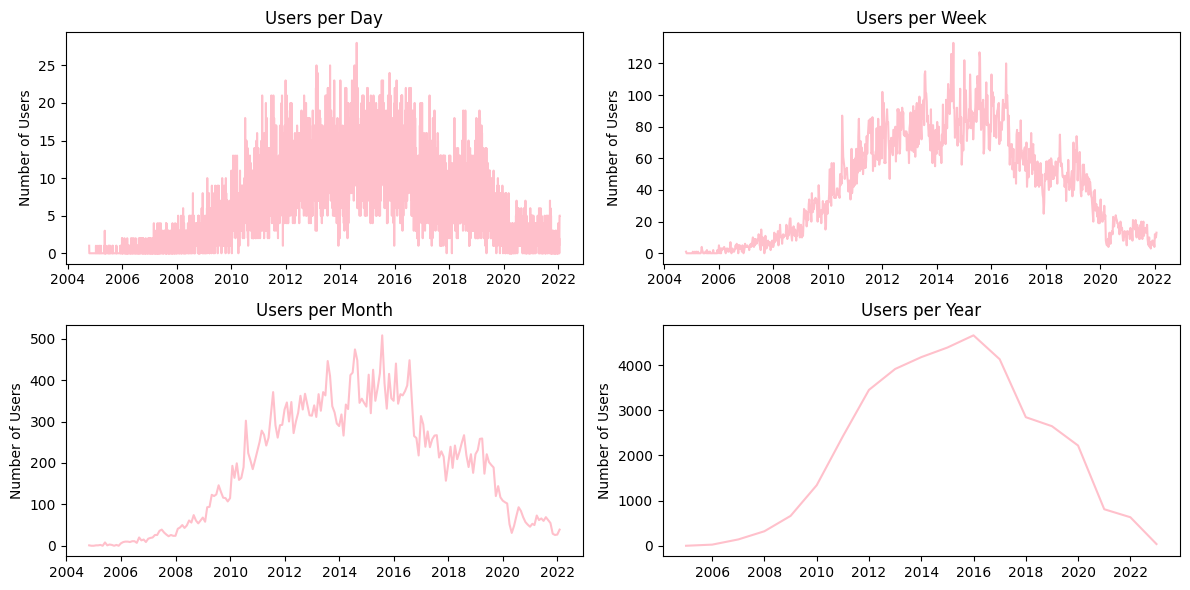

In [31]:
# time series plot for users

time_series_plot(users_per_day, users_per_week, users_per_month, users_per_year, content='Users')

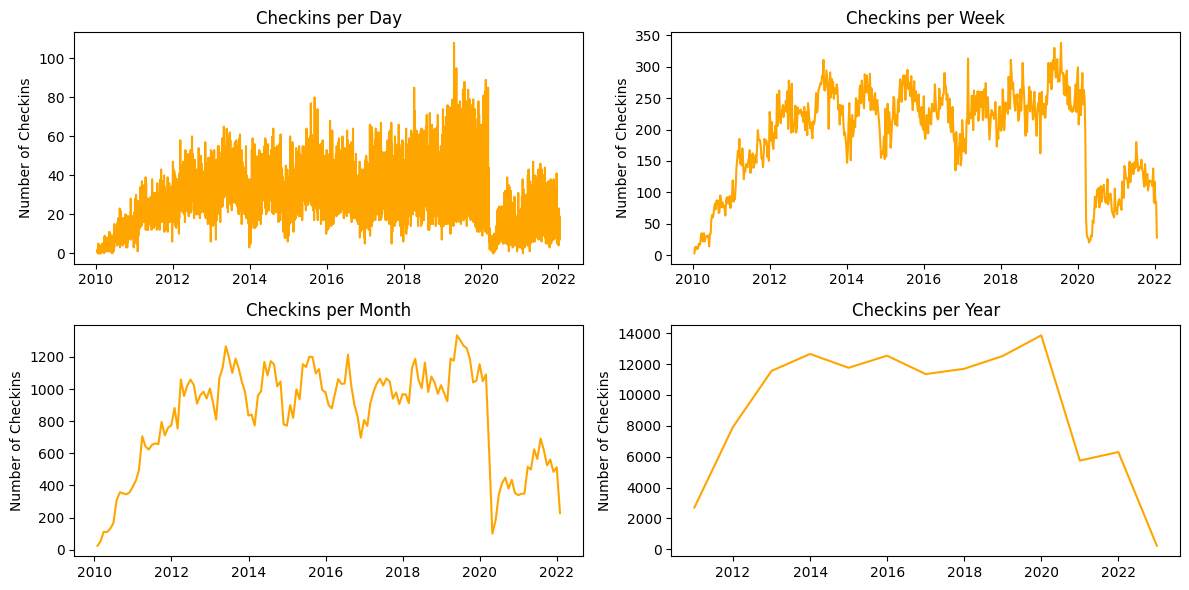

In [32]:
# time series plot for checkins

time_series_plot(checkins_per_day, checkins_per_week, checkins_per_month, checkins_per_year, content='Checkins')

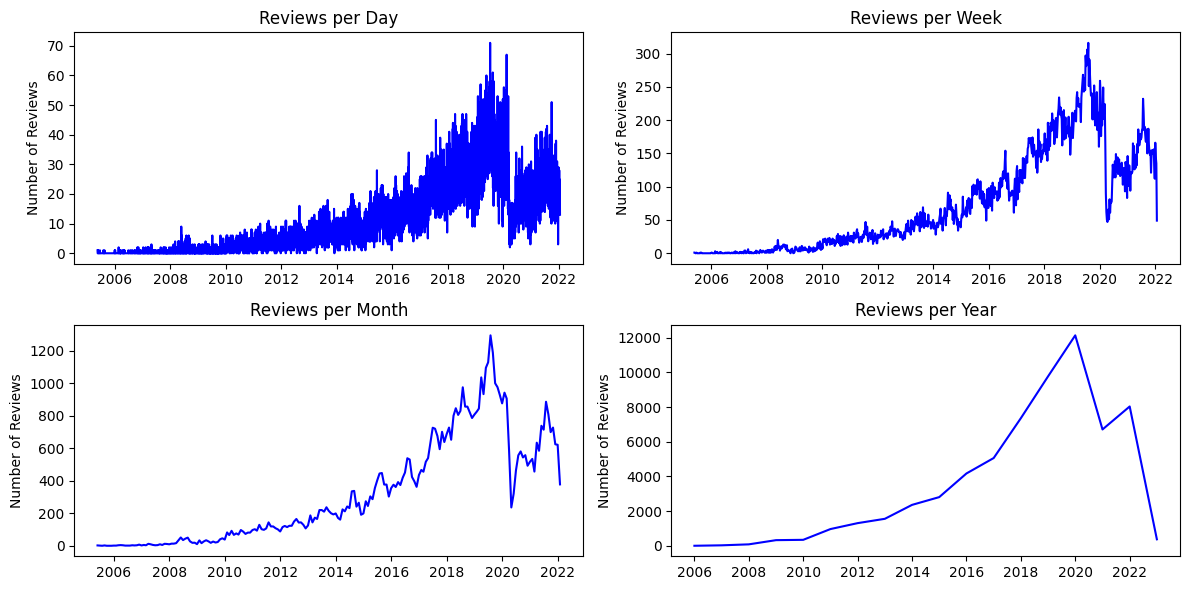

In [33]:
# time series plot for reviews

time_series_plot(reviews_per_day, reviews_per_week, reviews_per_month, reviews_per_year, content='Reviews')

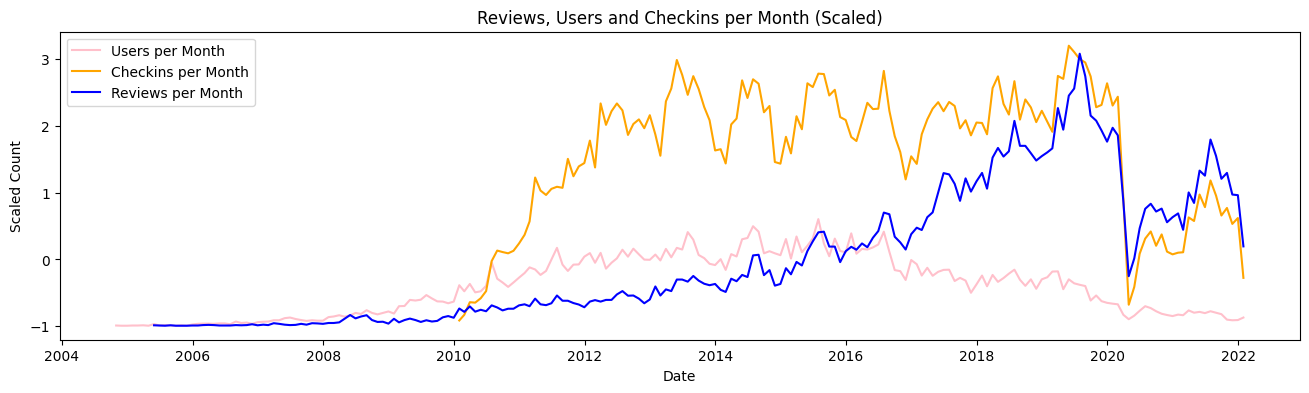

In [34]:
# comparison between reviews, users and checkins over time (with standardization)

scaler = StandardScaler()

reviews_per_month_scaled = scaler.fit_transform(reviews_per_month.values.reshape(-1, 1))
users_per_month_scaled = scaler.transform(users_per_month.values.reshape(-1, 1))
checkins_per_month_scaled = scaler.transform(checkins_per_month.values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(users_per_month.index, users_per_month_scaled, color='pink', label='Users per Month')
ax.plot(checkins_per_month.index, checkins_per_month_scaled, color='orange', label='Checkins per Month')
ax.plot(reviews_per_month.index, reviews_per_month_scaled, color='blue', label='Reviews per Month')
ax.set_title('Reviews, Users and Checkins per Month (Scaled)')
ax.set_xlabel('Date')
ax.set_ylabel('Scaled Count')
ax.legend()
plt.show()

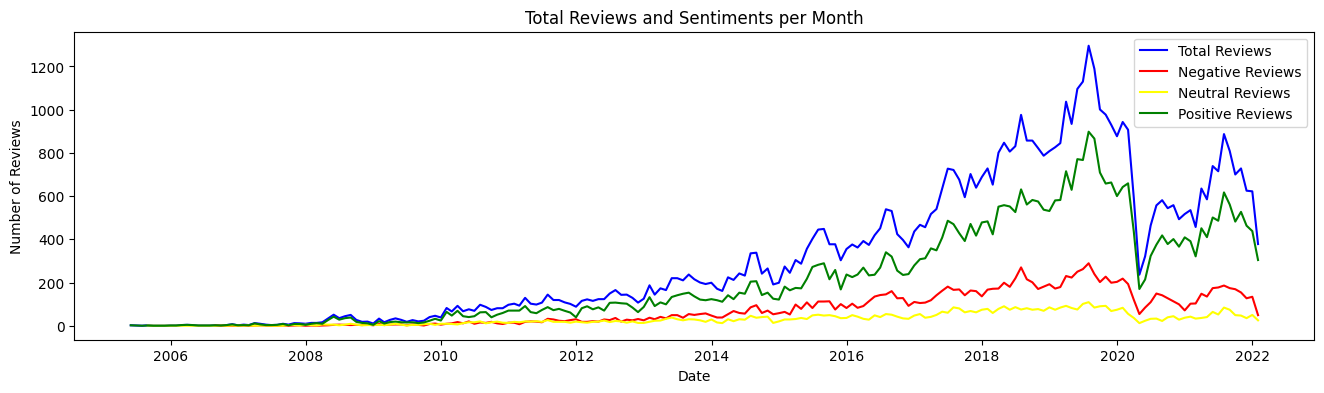

In [99]:
# comparison of total reviews and sentiments per month

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(reviews_per_month.index, reviews_per_month, color='blue', label='Total Reviews')
ax.plot(negative_reviews_per_month.index, negative_reviews_per_month, color='red', label='Negative Reviews')
ax.plot(neutral_reviews_per_month.index, neutral_reviews_per_month, color='yellow', label='Neutral Reviews')
ax.plot(positive_reviews_per_month.index, positive_reviews_per_month, color='green', label='Positive Reviews')

ax.set_title('Total Reviews and Sentiments per Month')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Reviews')
ax.legend()
plt.show()

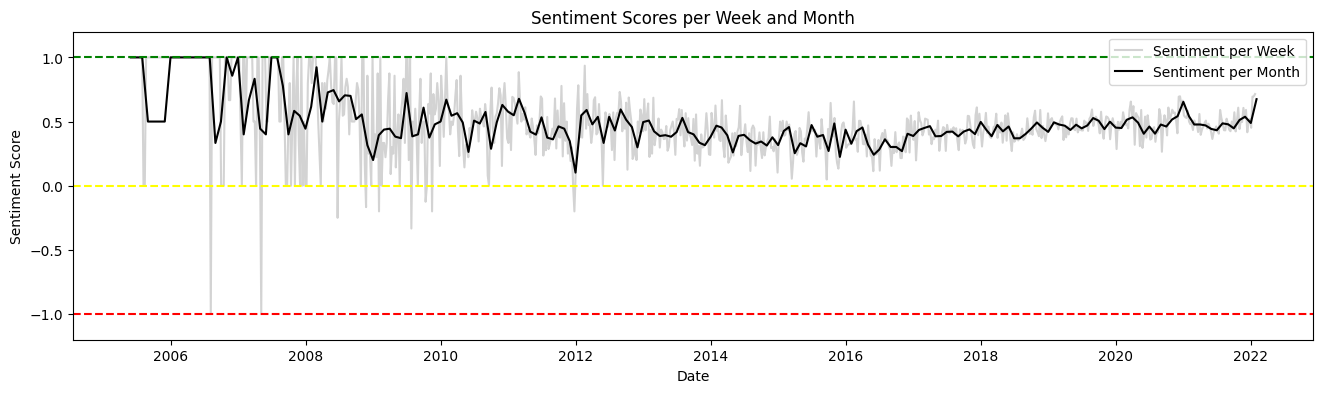

In [36]:
# time series of sentiment scores per week and month

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(sentiment_per_week, color='lightgray', label='Sentiment per Week')
ax.plot(sentiment_per_month, color='black', label='Sentiment per Month')

plt.ylim(-1.2, 1.2)
plt.axhline(y=1, color='green', linestyle='--')
plt.axhline(y=0, color='yellow', linestyle='--')
plt.axhline(y=-1, color='red', linestyle='--')

plt.title('Sentiment Scores per Week and Month')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

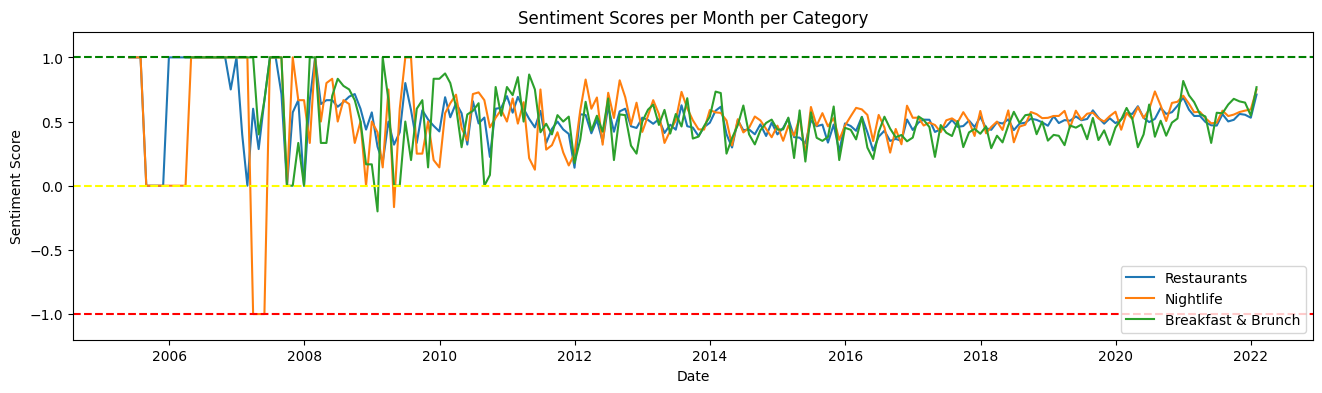

In [42]:
# time series of sentiment scores per month per category

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(sentiment_restaurants_per_month, label='Restaurants')
ax.plot(sentiment_nightlife_per_month, label='Nightlife')
ax.plot(sentiment_breakfast_brunch_per_month, label='Breakfast & Brunch')

plt.ylim(-1.2, 1.2)
plt.axhline(y=1, color='green', linestyle='--')
plt.axhline(y=0, color='yellow', linestyle='--')
plt.axhline(y=-1, color='red', linestyle='--')

plt.title('Sentiment Scores per Month per Category')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

### Autocorrelation and partial autocorrelation

In [43]:
def lag_plots(time_series, lags=5, title='Lag Plots'):
    '''
    Plot lag plots for time series data
    '''
    fig, axes = plt.subplots(nrows=1, ncols=lags, figsize=(15, 3))

    for lag in range(1, lags + 1):
        ax = axes[lag - 1]
        lag_plot(time_series, lag=lag, ax=ax)
        ax.set_title(f'Lag {lag}')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

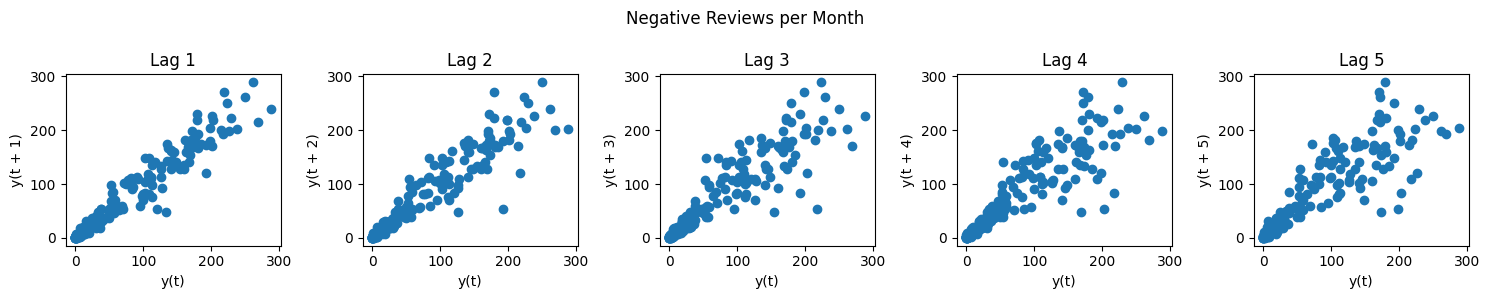

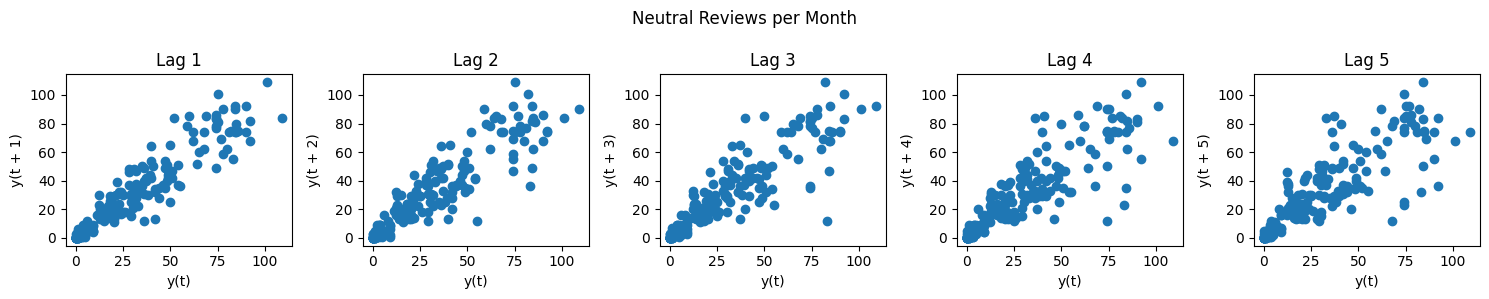

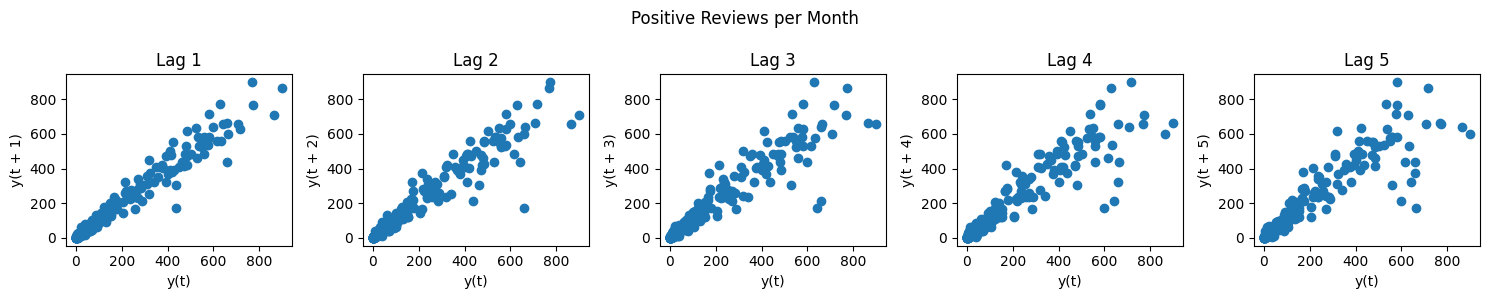

In [93]:
# lag plots for negative, neutral, and positive reviews per month

lag_plots(negative_reviews_per_month, lags=5, title='Negative Reviews per Month')
lag_plots(neutral_reviews_per_month, lags=5, title='Neutral Reviews per Month')
lag_plots(positive_reviews_per_month, lags=5, title='Positive Reviews per Month')

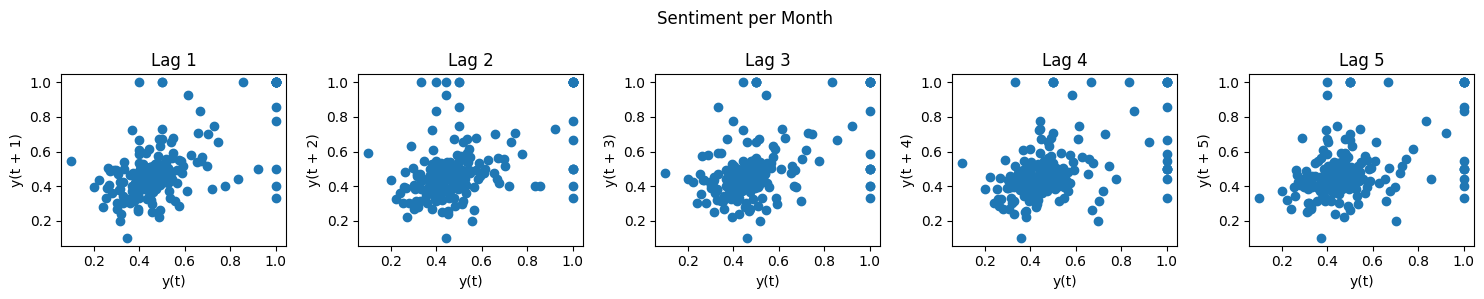

In [47]:
# lag plots for sentiment scores per month

lag_plots(sentiment_per_month, lags=5, title='Sentiment per Month')

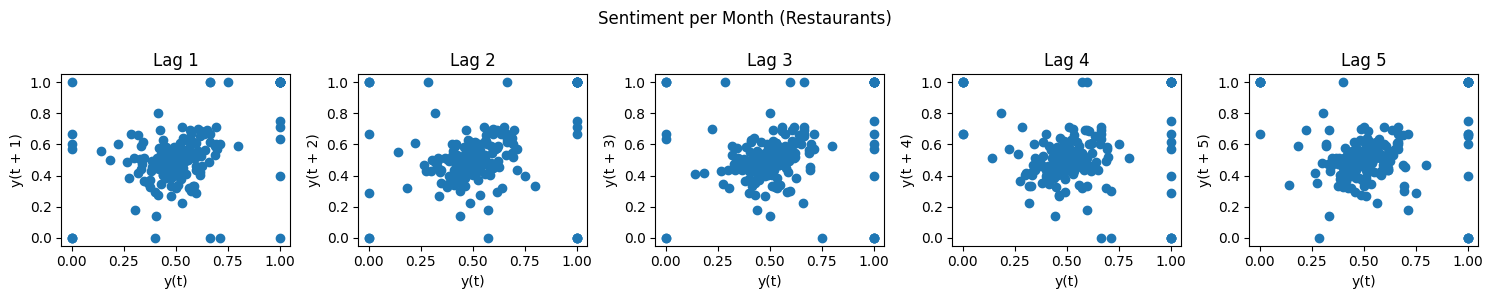

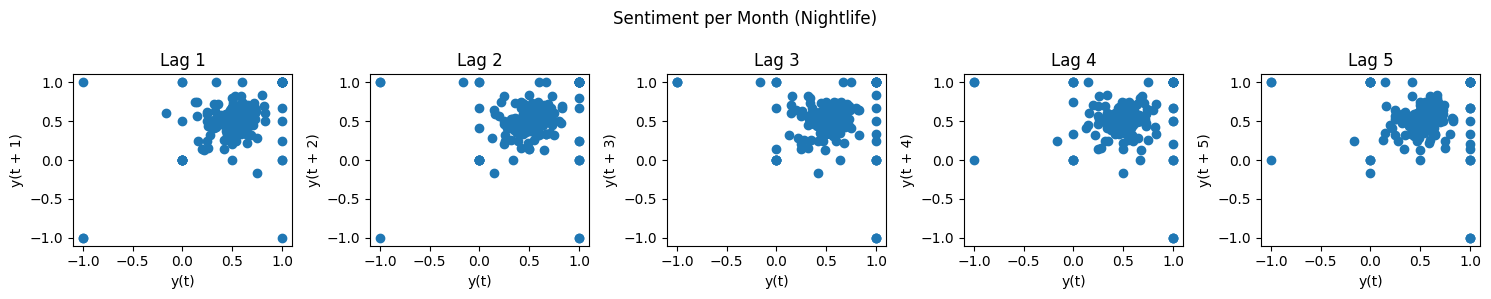

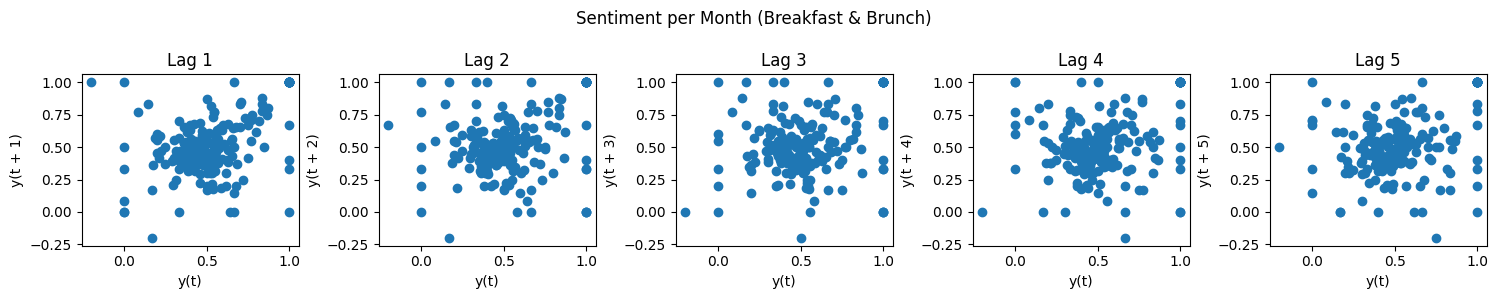

In [95]:
# lag plots for sentiment scores per month per category

lag_plots(sentiment_restaurants_per_month, lags=5, title='Sentiment per Month (Restaurants)')
lag_plots(sentiment_nightlife_per_month, lags=5, title='Sentiment per Month (Nightlife)')
lag_plots(sentiment_breakfast_brunch_per_month, lags=5, title='Sentiment per Month (Breakfast & Brunch)')

In [48]:
def acf_and_pacf_plots(time_series, title='ACF and PACF Plots'):
    '''
    Plot ACF and PACF plots for time series data
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    plot_acf(time_series, ax=axes[0])
    plot_pacf(time_series, ax=axes[1])

    axes[0].set_title('ACF')
    axes[1].set_title('PACF')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

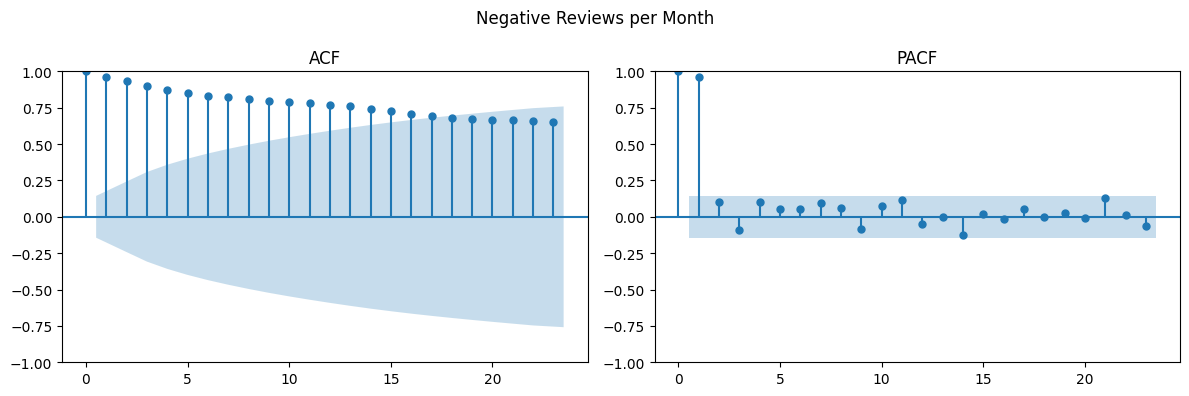

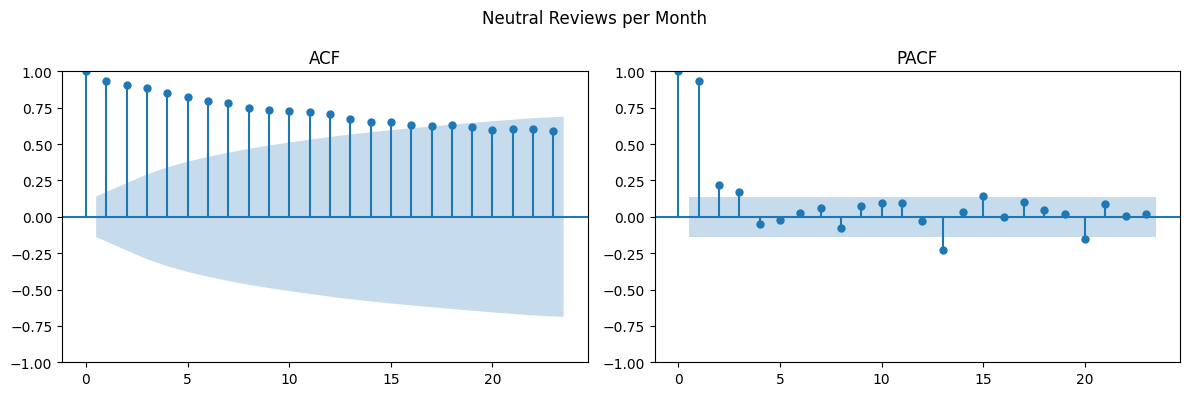

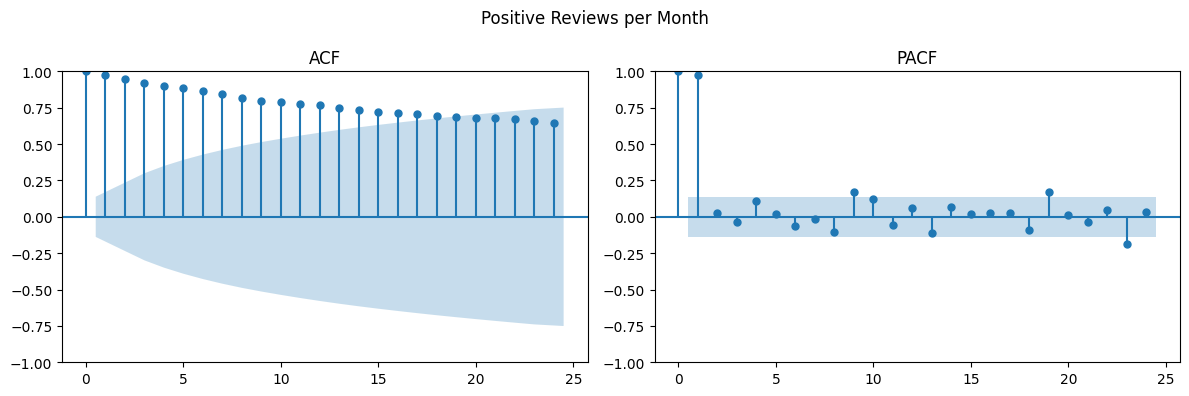

In [94]:
# ACF and PACF plots for negative, neutral, and positive reviews per month

acf_and_pacf_plots(negative_reviews_per_month, title='Negative Reviews per Month')
acf_and_pacf_plots(neutral_reviews_per_month, title='Neutral Reviews per Month')
acf_and_pacf_plots(positive_reviews_per_month, title='Positive Reviews per Month')

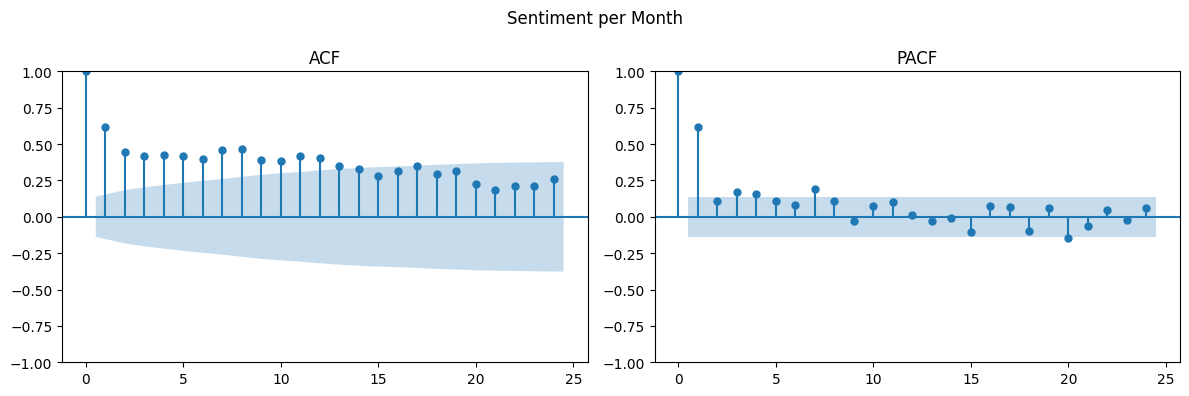

In [52]:
# autocorrelation function for sentiment scores per month

acf_and_pacf_plots(sentiment_per_month, title='Sentiment per Month')

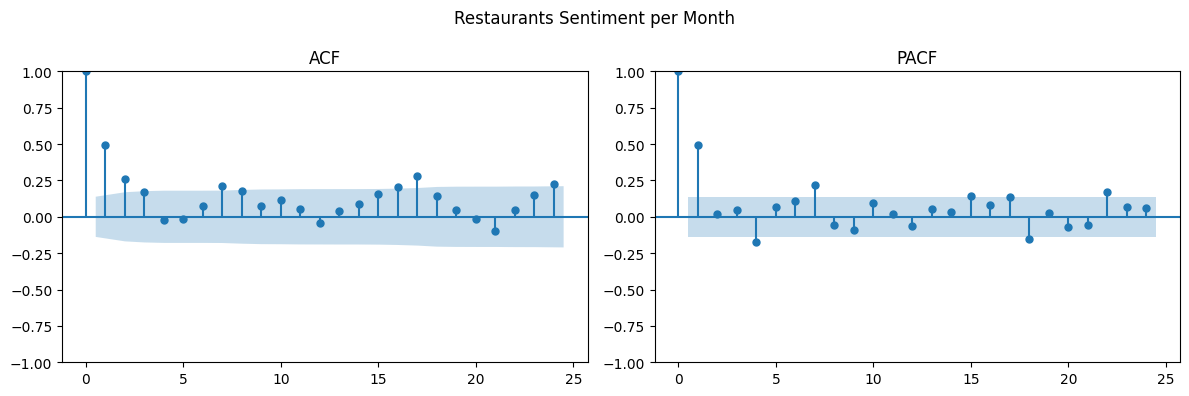

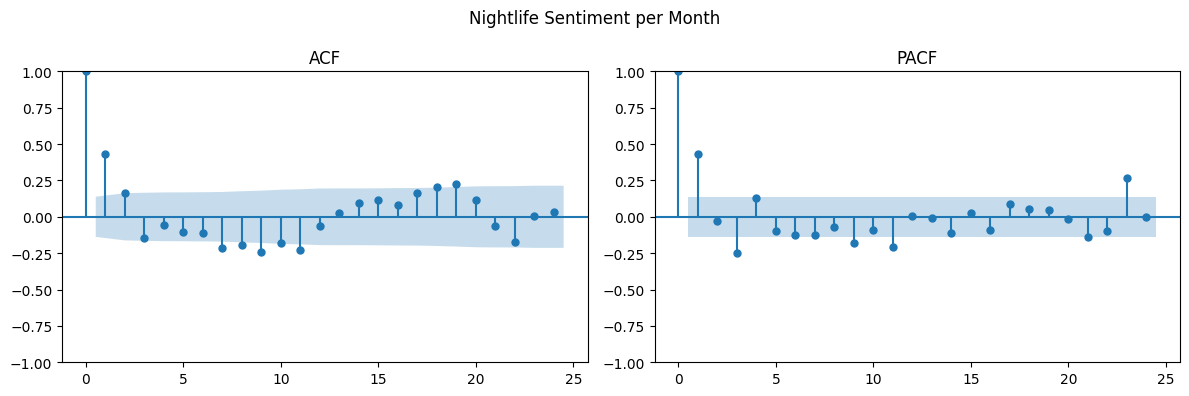

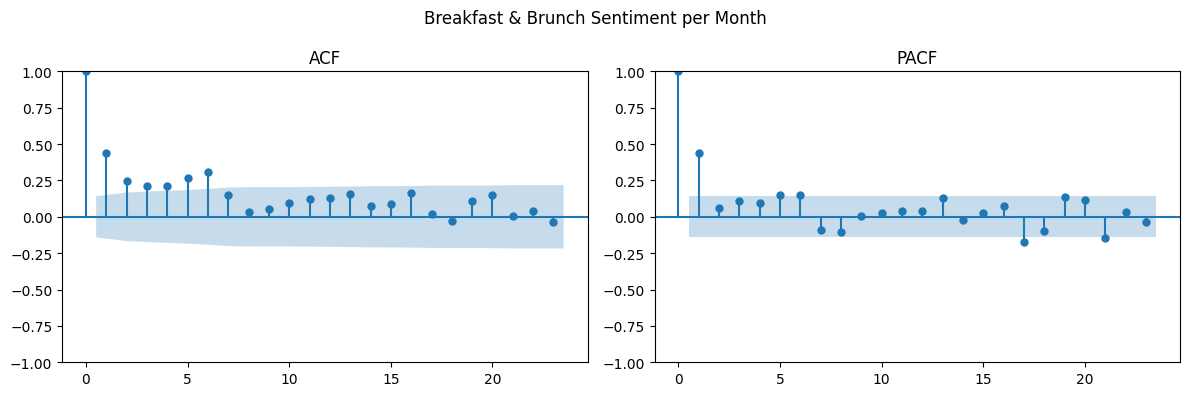

In [53]:
# autocorrelation function for category sentiment scores per month

acf_and_pacf_plots(sentiment_restaurants_per_month, title='Restaurants Sentiment per Month')
acf_and_pacf_plots(sentiment_nightlife_per_month, title='Nightlife Sentiment per Month')
acf_and_pacf_plots(sentiment_breakfast_brunch_per_month, title='Breakfast & Brunch Sentiment per Month')

### Stationarity

In [85]:
def stationarity_adf(time_series, extra_info=False):
    '''
    Check stationarity with Augmented Dickey-Fuller test
    '''
    adf_test = adfuller(time_series, autolag='AIC', regression='ct')
    print("ADF Test Results")
    if extra_info:
        print("Null Hypothesis: The series has a unit root (non-stationary)")
        print(f"ADF Statistic: {adf_test[0]}")
        print(f"p-value: {adf_test[1]}")
        print(f"Used Lags: {adf_test[2]}")
        print(f"Number of Observations: {adf_test[3]}")
        print(f"Critical Values: {adf_test[4]}")
        print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
    is_stationary = adf_test[1] < 0.05
    print(f"Is the series stationary? {is_stationary}")

In [86]:
def stationary_kpss(time_series, extra_info=False):
    '''
    Check stationarity with Kwiatkowski-Phillips-Schmidt-Shin test
    '''
    kpss_test = kpss(time_series, regression='ct', nlags='auto')
    print("KPSS Test Results")
    if extra_info:
        print("Null Hypothesis: The series is stationary")
        print(f"KPSS Statistic: {kpss_test[0]}")
        print(f"p-value: {kpss_test[1]}")
        print(f"Used Lags: {kpss_test[2]}")
        print(f"Critical Values: {kpss_test[3]}")
        print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is non-stationary")
    is_non_stationary = kpss_test[1] < 0.05
    print(f"Is the series non-stationary? {is_non_stationary}")
    print("Note: Test statistic being outside of the range of p-values available in the lookup table \
        \nindicates very strong evidence against the null hypothesis of stationarity.")

In [87]:
def stationary_pp(time_series, extra_info=False):
    '''
    Check stationarity with Phillips-Perron test
    '''
    pp_test = PhillipsPerron(time_series, trend='ct')
    print("Phillips-Perron Test Results")
    if extra_info:
        print("Null Hypothesis: The series has a unit root (non-stationary)")
        print(f"PP Statistic: {pp_test.stat}")
        print(f"p-value: {pp_test.pvalue}")
        print(f"Used Lags: {pp_test.lags}")
        print(f"Critical Values: {pp_test.critical_values}")
        print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
    is_stationary = pp_test.pvalue < 0.05
    print(f"Is the series stationary? {is_stationary}")

In [88]:
# ADF test on sentiment time series

stationarity_adf(sentiment_per_month['sentiment'])

ADF Test Results
Is the series stationary? False


In [89]:
# KPSS test on sentiment time series

stationary_kpss(sentiment_per_month['sentiment'])

KPSS Test Results
Is the series non-stationary? True
Note: Test statistic being outside of the range of p-values available in the lookup table         
indicates very strong evidence against the null hypothesis of stationarity.


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10900\2087464908.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(time_series, regression='ct', nlags='auto')


In [90]:
# PP test on sentiment time series

stationary_pp(sentiment_per_month['sentiment'])

Phillips-Perron Test Results
Is the series stationary? True


In [92]:
# stationarity tests on category sentiment time series

sentiment_cat_name = ['Restaurants', 'Nightlife', 'Breakfast & Brunch']
sentiment_cat_ts = [sentiment_restaurants_per_month, sentiment_nightlife_per_month, sentiment_breakfast_brunch_per_month]

for i, sentiment in enumerate(sentiment_cat_ts):
    print(f'Category: {sentiment_cat_name[i]}\n')
    stationarity_adf(sentiment['sentiment'])
    print()
    stationary_kpss(sentiment['sentiment'])
    print()
    stationary_pp(sentiment['sentiment'])
    print('-' * 50)

Category: Restaurants

ADF Test Results
Is the series stationary? False

KPSS Test Results
Is the series non-stationary? True
Note: Test statistic being outside of the range of p-values available in the lookup table         
indicates very strong evidence against the null hypothesis of stationarity.

Phillips-Perron Test Results
Is the series stationary? True
--------------------------------------------------
Category: Nightlife

ADF Test Results
Is the series stationary? True

KPSS Test Results
Is the series non-stationary? False
Note: Test statistic being outside of the range of p-values available in the lookup table         
indicates very strong evidence against the null hypothesis of stationarity.

Phillips-Perron Test Results
Is the series stationary? True
--------------------------------------------------
Category: Breakfast & Brunch

ADF Test Results
Is the series stationary? True

KPSS Test Results
Is the series non-stationary? True
Note: Test statistic being outside of the ra

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10900\2087464908.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(time_series, regression='ct', nlags='auto')
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10900\2087464908.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(time_series, regression='ct', nlags='auto')
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10900\2087464908.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(time_series, regression='ct', nlags='auto')
